# Labo III
# Multinacional - Prediccion de Ventas

In [74]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from tslearn.utils import to_time_series_dataset
from tslearn.metrics import cdist_dtw
from tslearn.clustering import TimeSeriesKMeans

## Cargo datasets y limpieza

In [75]:
# Load the data aggregated_montly_sales.csv using pandas
data = pd.read_csv('datasets/aggregated_montly_sales.csv', parse_dates=['periodo'])

In [76]:
data.head()

,periodo,product_id,tn,cat1,cat2,cat3,brand,sku_size,descripcion,ipc,exchange_rate
0,2017-01-01,20001,934.77220,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1.6,16.96
1,2017-01-01,20002,550.15704,HC,ROPA LAVADO,Liquido,LIMPIEX,3000.0,Maquina 1er lavado,1.6,16.96
2,2017-01-01,20003,1063.45840,FOODS,ADEREZOS,Mayonesa,NATURA,475.0,Regular sin TACC,1.6,16.96
3,2017-01-01,20004,555.91614,FOODS,ADEREZOS,Mayonesa,NATURA,240.0,Regular sin TACC,1.6,16.96
4,2017-01-01,20005,494.27010,FOODS,ADEREZOS,Mayonesa,NATURA,120.0,Regular sin TACC,1.6,16.96


In [77]:
print(data.shape)
print(data.dtypes)

(31243, 11)
periodo          datetime64[ns]
product_id                int64
tn                      float64
cat1                     object
cat2                     object
cat3                     object
brand                    object
sku_size                float64
descripcion              object
ipc                     float64
exchange_rate           float64
dtype: object


In [78]:
data = data.sort_values(["product_id", "periodo"]).reset_index(drop=True)

## Fill with 0 when there were no sales

In [79]:
# ─────────────────────────────────────────────────────────────────────────────
# Build a COMPLETE product-month grid (0 = “no sales that month”)
# ─────────────────────────────────────────────────────────────────────────────
static_cols  = ["cat1", "cat2", "cat3", "brand", "sku_size"]
dynamic_cols = ["tn", "ipc", "exchange_rate"]           # metrics that vary monthly

# 1) One clean row per SKU with its static descriptors
sku_static = (
    data
      .sort_values(static_cols)         # deterministic pick
      .groupby("product_id", as_index=False)[static_cols]
      .first()
)

# 2) All calendar months present in the dataset
all_months = pd.period_range(
                data["periodo"].min(),
                data["periodo"].max(),
                freq="M"
             ).to_timestamp()            # → Timestamp('YYYY-MM-01')

# 3) Cartesian product: every (product_id, month) combination
full_idx = pd.MultiIndex.from_product(
             [sku_static["product_id"], all_months],
             names=["product_id", "periodo"]
           )

# 4) Keep ONLY the dynamic columns while re-indexing to avoid duplicate statics
data_dyn = data[["product_id", "periodo", *dynamic_cols]]

monthly_full = (
    data_dyn
      .set_index(["product_id", "periodo"])
      .reindex(full_idx, fill_value=0)     # zero = “no activity” month
      .reset_index()
)

# 5) Bring static attributes back exactly once
monthly_full = (
    monthly_full
      .merge(sku_static, on="product_id", how="left", validate="many_to_one")
      .sort_values(["product_id", "periodo"])
      .reset_index(drop=True)
)


In [80]:
print(monthly_full.shape)
print(monthly_full.head().to_string())

(44388, 10)
   product_id    periodo         tn  ipc  exchange_rate cat1         cat2     cat3  brand  sku_size
0       20001 2017-01-01   934.7722  1.6          16.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
1       20001 2017-02-01   798.0162  2.1          16.59   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
2       20001 2017-03-01  1303.3577  2.4          16.21   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
3       20001 2017-04-01  1069.9613  2.7          15.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0
4       20001 2017-05-01  1502.2013  1.4          15.95   HC  ROPA LAVADO  Liquido  ARIEL    3000.0


# Normalizo

In [81]:
# Compute mean and standard deviation per product
product_summary = (
    monthly_full
    .groupby('product_id')
    .agg(
        tn_mean=('tn', 'mean'),
        tn_std =('tn', 'std'),
    )
    .reset_index()
)

print(product_summary.head())
print(product_summary.shape)

   product_id      tn_mean      tn_std
0       20001  1398.344308  298.145447
1       20002  1009.368185  303.834847
2       20003   889.004249  292.036596
3       20004   671.615379  224.450078
4       20005   644.200514  218.273229
(1233, 3)


In [82]:
monthly_full = (
    monthly_full
    .merge(product_summary, on='product_id', how='left')
)

monthly_full['tn_normalized'] = (
    (monthly_full['tn'] - monthly_full['tn_mean'])
    / monthly_full['tn_std']
)

In [83]:
print(monthly_full.head().to_string())

   product_id    periodo         tn  ipc  exchange_rate cat1         cat2     cat3  brand  sku_size      tn_mean      tn_std  tn_normalized
0       20001 2017-01-01   934.7722  1.6          16.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -1.554852
1       20001 2017-02-01   798.0162  2.1          16.59   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -2.013541
2       20001 2017-03-01  1303.3577  2.4          16.21   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -0.318592
3       20001 2017-04-01  1069.9613  2.7          15.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -1.101419
4       20001 2017-05-01  1502.2013  1.4          15.95   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447       0.348343


# Clusterizo con DTW y KM

In [84]:
# Calculo DTW

# 1. Pivot the DataFrame so each product_id becomes a row and each periodo a column
#    missing tn_normalized will be filled with 0
pivot_pd = monthly_full.pivot_table(
    index='product_id',
    columns='periodo',
    values='tn_normalized',
    fill_value=0
)

# 2. (Optional but recommended) Sort the time‐columns so they’re in chronological order
pivot_pd = pivot_pd.sort_index(axis=1)

# 3. Convert to numpy + tslearn dataset
#    This will give you an array of shape (n_products, n_timepoints, 1)
X = to_time_series_dataset(pivot_pd.values)

In [85]:
'''# Clusterizo

inertia = []
K = range(2, 50)

for k in K:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=False)
    model.fit(X)
    inertia.append(model.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (DTW)")
plt.title("Elbow Method for DTW Clustering")
plt.show()
'''

'# Clusterizo\n\ninertia = []\nK = range(2, 50)\n\nfor k in K:\n    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=False)\n    model.fit(X)\n    inertia.append(model.inertia_)\n\nplt.plot(K, inertia, marker=\'o\')\nplt.xlabel("Number of clusters")\nplt.ylabel("Inertia (DTW)")\nplt.title("Elbow Method for DTW Clustering")\nplt.show()\n'

In [ ]:
# Clusterizo

N_CLUSTERS = 15

# 1. Fit the TS-KMeans model on your time-series dataset X
model = TimeSeriesKMeans(n_clusters=N_CLUSTERS, metric="dtw", verbose=False)
cluster_labels = model.fit_predict(X)

# 2. Build a pandas DataFrame from the pivot index and your labels
product_clusters = pd.DataFrame({
    "product_id": pivot_pd.index,
    "cluster":    cluster_labels
}).reset_index(drop=True)

print(product_clusters.head())

In [113]:
# Count products in each cluster
cluster_counts = (
    product_clusters
    .groupby('cluster')
    .size()                        # count rows per cluster
    .reset_index(name='count')    # turn it into a DataFrame
    .sort_values('count', ascending=False)
    .head(N_CLUSTERS)
)

print(cluster_counts)

    cluster  count
3         3    126
8         8    121
14       14    121
12       12     99
7         7     95
10       10     95
9         9     94
4         4     84
11       11     82
5         5     78
2         2     62
1         1     54
0         0     52
13       13     38
6         6     32


In [88]:
# Agrego numero de cluster al dataset original

monthly_full = monthly_full.merge(product_clusters, on='product_id', how='left')

In [89]:
print(monthly_full.head().to_string())

   product_id    periodo         tn  ipc  exchange_rate cat1         cat2     cat3  brand  sku_size      tn_mean      tn_std  tn_normalized  cluster
0       20001 2017-01-01   934.7722  1.6          16.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -1.554852        0
1       20001 2017-02-01   798.0162  2.1          16.59   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -2.013541        0
2       20001 2017-03-01  1303.3577  2.4          16.21   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -0.318592        0
3       20001 2017-04-01  1069.9613  2.7          15.96   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447      -1.101419        0
4       20001 2017-05-01  1502.2013  1.4          15.95   HC  ROPA LAVADO  Liquido  ARIEL    3000.0  1398.344308  298.145447       0.348343        0


# Total Forecast Error (TFE)
Usamos la formula para medir el error de las predicciones:
$$
\text{TFE} = \frac{\sum_i \left| \hat{y}_i - y_i \right|}{\sum_i y_i}
$$


In [90]:
def total_forecast_error(y_true, y_pred):
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true)



# Feature Engineering

In [91]:
# Sort the data by product_id and periodo
monthly_full = monthly_full.sort_values(["product_id", "periodo"]).reset_index(drop=True)

In [92]:
monthly_full["y"] = (
    monthly_full.groupby("product_id")["tn"]
      .shift(-2)                             # +2-month look-ahead
)

In [93]:
# ─────────────────────────────────────────────────────────────────────────────
# Lag features 
# ─────────────────────────────────────────────────────────────────────────────

LAGS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]                     # months
for lag in LAGS:
    monthly_full[f"tn_lag_{lag}"] = (
        monthly_full.groupby("product_id")["tn"].shift(lag)
    )

In [94]:
# ─────────────────────────────────────────────────────────────────────────────
# Rolling mean features
# ─────────────────────────────────────────────────────────────────────────────

# windows you want; order doesn’t matter
ROLL_WINDOWS = [3, 6, 12]

for w in ROLL_WINDOWS:
    monthly_full[f"tn_roll_mean_{w}"] = (
        monthly_full
            .groupby("product_id")["tn"]
            .transform(lambda s: s.rolling(w, min_periods=1).mean())
            .astype("float32")
    )

In [95]:
# Drop categoricals (for now) and ipc and exchange_rate
monthly_full = monthly_full.drop(columns=["cat1", "cat2", "cat3", "brand", "ipc", "exchange_rate", "sku_size"])

In [96]:
# Count missing values per column
missing_counts = monthly_full.isnull().sum()
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

Missing values per column:
y             2466
tn_lag_1      1233
tn_lag_2      2466
tn_lag_3      3699
tn_lag_4      4932
tn_lag_5      6165
tn_lag_6      7398
tn_lag_7      8631
tn_lag_8      9864
tn_lag_9     11097
tn_lag_10    12330
tn_lag_11    13563
tn_lag_12    14796
dtype: int64


In [97]:
monthly_full.dtypes

product_id                  int64
periodo            datetime64[ns]
tn                        float64
tn_mean                   float64
tn_std                    float64
tn_normalized             float64
cluster                     int64
y                         float64
tn_lag_1                  float64
tn_lag_2                  float64
tn_lag_3                  float64
tn_lag_4                  float64
tn_lag_5                  float64
tn_lag_6                  float64
tn_lag_7                  float64
tn_lag_8                  float64
tn_lag_9                  float64
tn_lag_10                 float64
tn_lag_11                 float64
tn_lag_12                 float64
tn_roll_mean_3            float32
tn_roll_mean_6            float32
tn_roll_mean_12           float32
dtype: object

# Train/Val split

In [98]:
cut_train_end = "2019-08-01"
cut_valid     = "2019-10-01"
cut_test      = "2019-12-01"

train_df = monthly_full[monthly_full["periodo"] <= cut_train_end]
valid_df = monthly_full[monthly_full["periodo"] == cut_valid]
test_df  = monthly_full[monthly_full["periodo"] == cut_test]          # the month to forecast

# Drop rows with NaN values
train_df = train_df.dropna()
valid_df = valid_df.dropna()

feature_cols = (
    [c for c in monthly_full.columns 
     if c not in ["periodo", "product_id", "y", "tn", "tn_normalized", "tn_mean", "tn_std"]]
)

X_train, y_train = train_df[feature_cols], train_df["y"]
X_valid, y_valid = valid_df[feature_cols], valid_df["y"]
X_test           =  test_df[feature_cols]

In [99]:
print(train_df.head().to_string())

    product_id    periodo         tn      tn_mean      tn_std  tn_normalized  cluster          y   tn_lag_1   tn_lag_2   tn_lag_3   tn_lag_4   tn_lag_5   tn_lag_6   tn_lag_7   tn_lag_8   tn_lag_9  tn_lag_10  tn_lag_11  tn_lag_12  tn_roll_mean_3  tn_roll_mean_6  tn_roll_mean_12
12       20001 2018-01-01  1169.0753  1398.344308  298.145447      -0.768984        0  1856.8353  1049.3885  1580.4740  1439.7556  1316.9460  1267.3947  1030.6740  1520.0654  1502.2013  1069.9613  1303.3577   798.0162   934.7722     1266.312622     1303.838989      1253.942505
13       20001 2018-02-01  1043.7646  1398.344308  298.145447      -1.189284        0  1251.2847  1169.0753  1049.3885  1580.4740  1439.7556  1316.9460  1267.3947  1030.6740  1520.0654  1502.2013  1069.9613  1303.3577   798.0162     1087.409424     1266.567383      1274.421509
14       20001 2018-03-01  1856.8353  1398.344308  298.145447       1.537810        0  1293.8978  1043.7646  1169.0753  1049.3885  1580.4740  1439.7556  1316.9460  12

In [100]:
# Count missing values per column
missing_counts = X_train.isnull().sum()
print("Missing values per column:")
print(missing_counts[missing_counts > 0])

Missing values per column:
Series([], dtype: int64)


# Fit Linear Regression

In [101]:
df_tr = train_df.loc[(monthly_full['cluster'] == 0)]
X_tr = df_tr[feature_cols]

print(X_tr.head().to_string()  )

    cluster   tn_lag_1   tn_lag_2   tn_lag_3   tn_lag_4   tn_lag_5   tn_lag_6   tn_lag_7   tn_lag_8   tn_lag_9  tn_lag_10  tn_lag_11  tn_lag_12  tn_roll_mean_3  tn_roll_mean_6  tn_roll_mean_12
12        0  1049.3885  1580.4740  1439.7556  1316.9460  1267.3947  1030.6740  1520.0654  1502.2013  1069.9613  1303.3577   798.0162   934.7722     1266.312622     1303.838989      1253.942505
13        0  1169.0753  1049.3885  1580.4740  1439.7556  1316.9460  1267.3947  1030.6740  1520.0654  1502.2013  1069.9613  1303.3577   798.0162     1087.409424     1266.567383      1274.421509
14        0  1043.7646  1169.0753  1049.3885  1580.4740  1439.7556  1316.9460  1267.3947  1030.6740  1520.0654  1502.2013  1069.9613  1303.3577     1356.558350     1356.548828      1320.544678
15        0  1856.8353  1043.7646  1169.0753  1049.3885  1580.4740  1439.7556  1316.9460  1267.3947  1030.6740  1520.0654  1502.2013  1069.9613     1383.961548     1325.137085      1335.654907
16        0  1251.2847  1856.8353  

In [102]:
cluster_models   = {}
cluster_metrics = []

# Loop over each cluster, fit a model, record diagnostics
for cluster_label in monthly_full['cluster'].unique():
    # Subset train and validation for this cluster
    df_tr = train_df.loc[(monthly_full['cluster'] == cluster_label)]
    df_va = valid_df.loc[(monthly_full['cluster'] == cluster_label)]
    
    X_tr = df_tr[feature_cols]
    y_tr = df_tr['y']
    X_va = df_va[feature_cols]
    y_va = df_va['y']
    
    # Skip clusters with too little data
    if len(df_tr) < len(feature_cols):
        continue
    
    # Fit the model
    model = LinearRegression(fit_intercept=True, n_jobs=-1)
    model.fit(X_tr, y_tr)
    cluster_models[cluster_label] = model
    
    # predictions
    y_pred_tr = model.predict(X_tr)
    y_pred_va = model.predict(X_va)

    # Compute R² and coefficient count
    r2_tr = model.score(X_tr, y_tr)
    r2_va = model.score(X_va, y_va) if len(df_va) > 0 else float('nan')
    n_coef = len(model.coef_)
    tfe_tr  = total_forecast_error(y_tr, y_pred_tr)
    tfe_va  = total_forecast_error(y_va, y_pred_va)
    
    cluster_metrics.append({
        'cluster':    cluster_label,
        'n_train':    len(df_tr),
        'n_valid':    len(df_va),
        'R2_train':   round(r2_tr, 3),
        'R2_valid':   round(r2_va, 3),
        'TFE_train':      round(tfe_tr, 4),
        'TFE_valid':      round(tfe_va, 4),
        'n_coefficients': n_coef
    })

# 4. View summary of all clusters
metrics_df = pd.DataFrame(cluster_metrics)
print(metrics_df)

    cluster  n_train  n_valid  R2_train      R2_valid  TFE_train  \
0         0     1280       64     0.959  9.490000e-01     0.2024   
1         3     1940       97     0.932  7.860000e-01     0.3444   
2        14     1260       63     0.950  9.930000e-01     0.3020   
3         9     1820       91     0.931  9.310000e-01     0.2326   
4         5     2040      102     0.882  9.010000e-01     0.2562   
5         8     1340       67     0.932  9.500000e-01     0.2558   
6         2     2920      146     0.910  4.920000e-01     0.2999   
7        12     1540       77     0.937  9.060000e-01     0.2950   
8        13     1840       92     0.808  3.790000e-01     0.6143   
9         7     2920      146     0.886  8.850000e-01     0.2329   
10        4     1840       92     0.664  9.260000e-01     0.7551   
11       10     1480       74     0.746 -3.573000e+00     1.2011   
12        1      820       41     0.696 -7.000000e-03     0.7304   
13       11      960       48     0.542 -4.97968

In [ ]:
#CAclulo TFE
# 2. Initialize your prediction column
valid_df['y_pred'] = np.nan

# 3. Fill in predictions per-cluster
for cluster_label, model in cluster_models.items():
    mask = valid_df['cluster'] == cluster_label
    if mask.any():
        X_va = valid_df.loc[mask, feature_cols]
        valid_df.loc[mask, 'y_pred'] = model.predict(X_va)

# 4. Compute Total Forecast Error on the full validation set
def total_forecast_error(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / y_true.sum()

overall_tfe = total_forecast_error(valid_df['y'], valid_df['y_pred'])
print("Overall Validation TotalForecastError:", round(overall_tfe, 4))

Overall Validation TotalForecastError: 113524883.1711


In [131]:
# 1. (Re)compute per‐row error
valid_df['error'] = (valid_df['y'] - valid_df['y_pred']).abs()

# 2. For each product_id, get the index of the row with max error
idx_of_max_error = valid_df.groupby('product_id')['error'].idxmax()

# 3. Select those rows, sort by error descending, and take top N
top_n = 10
top_rows = (
    valid_df
    .loc[idx_of_max_error]                      # one row per product at its max‐error point
    .sort_values('error', ascending=False)     # largest errors first
    .head(top_n)                               # top N products
)

# 4. Print the columns you want
print(top_rows[['product_id', 'periodo', 'y', 'y_pred', 'error']])


      product_id    periodo           y        y_pred         error
610        20615 2019-10-01    14.06805 -1.273963e+12  1.273963e+12
657        20662 2019-10-01    11.50205 -9.116483e+11  9.116483e+11
912        20933 2019-10-01     3.68027 -2.580144e+11  2.580144e+11
1074       21111 2019-10-01     1.46188 -1.861733e+11  1.861733e+11
1077       21114 2019-10-01     1.49352 -1.551531e+11  1.551531e+11
1007       21035 2019-10-01     1.80884 -1.094929e+11  1.094929e+11
437        20440 2019-10-01    34.28062 -8.184493e+10  8.184493e+10
1          20002 2019-10-01  1087.30860  1.546028e+03  4.587195e+02
31         20032 2019-10-01   527.79810  8.972112e+02  3.694131e+02
0          20001 2019-10-01  1504.68860  1.728734e+03  2.240455e+02


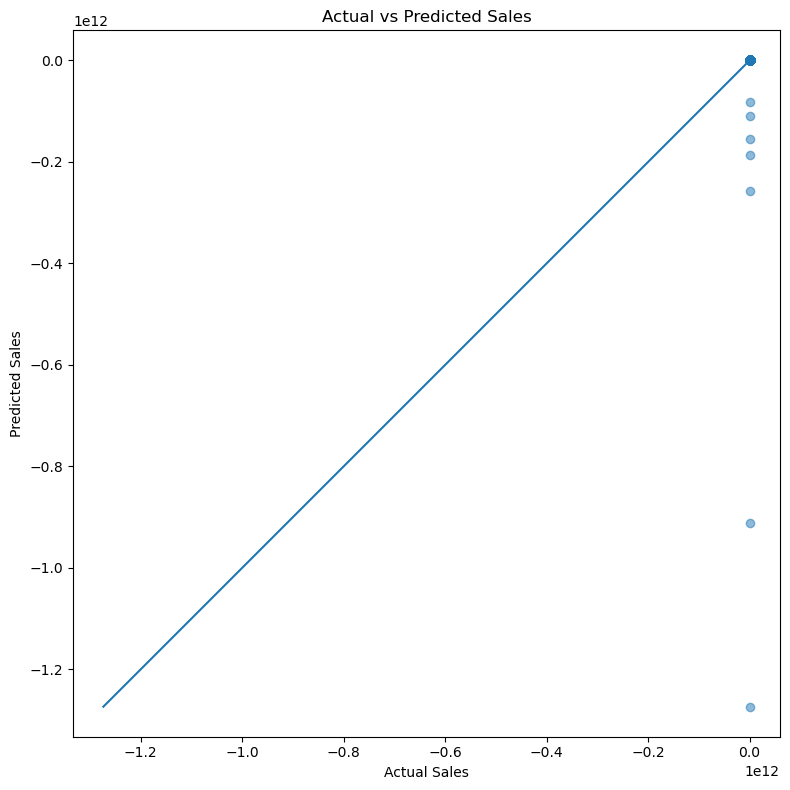

In [119]:
# Grafico prediccion vs real

plt.figure(figsize=(8, 8))
plt.scatter(valid_df['y'], valid_df['y_pred'], alpha=0.5)

# Diagonal 45° line (ideal prediction)
min_val = min(valid_df['y'].min(), valid_df['y_pred'].min())
max_val = max(valid_df['y'].max(), valid_df['y_pred'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.axis('equal')  # ensure the scales are the same on both axes
plt.tight_layout()
plt.show()

# Forecast Feb 2020

In [132]:
# 3. Loop over each cluster, predict only for that cluster’s rows
for cluster_label, model in cluster_models.items():
    mask = test_df['cluster'] == cluster_label
    if mask.any():
        X_test_cluster = test_df.loc[mask, feature_cols]
        test_df.loc[mask, 'pred_tn'] = model.predict(X_test_cluster)

# 4. Build your final forecast DataFrame
forecast_feb2020 = (
    test_df[['product_id', 'pred_tn']]
    .rename(columns={'pred_tn': 'forecast_tn'})
)

print(forecast_feb2020.head())

   product_id  forecast_tn
0       20001  1554.883726
1       20002  1011.220768
2       20003   709.875930
3       20004   532.770349
4       20005   452.490438


# Calculo promedio 12 meses

In [123]:
# PARA OCTUBRE 2019

# ensure periodo is datetime
monthly_full['periodo'] = pd.to_datetime(monthly_full['periodo'])

# define your 12-month window
last_date = pd.to_datetime(cut_valid)
start_date = last_date - pd.DateOffset(months=12) + pd.DateOffset(days=1)

# filter to that window
mask = (monthly_full['periodo'] >= start_date) & (monthly_full['periodo'] <= last_date)
window_df = monthly_full.loc[mask]

# compute the mean tn per product_id
avg_12m = (
    window_df
    .groupby('product_id')['tn']
    .mean()
    .reset_index(name='avg_sales_last_12m')
)

print(avg_12m.head())

# TFE
# 1. Merge the naive forecast into your test set
valid_df = valid_df.merge(avg_12m, on='product_id', how='left')

# 2. Use the 12-month average as your forecast
valid_df['forecast_tn'] = valid_df['avg_sales_last_12m']

# 3. Compute Total Forecast Error
tfe = (
    (valid_df['forecast_tn'] - valid_df['tn'])
    .abs()
    .sum()
    / valid_df['tn'].sum()
)

print("Total Forecast Error:", round(tfe, 4))


   product_id  avg_sales_last_12m
0       20001         1487.869450
1       20002         1197.552089
2       20003          796.305677
3       20004          629.387768
4       20005          638.415243
Total Forecast Error: 0.2884


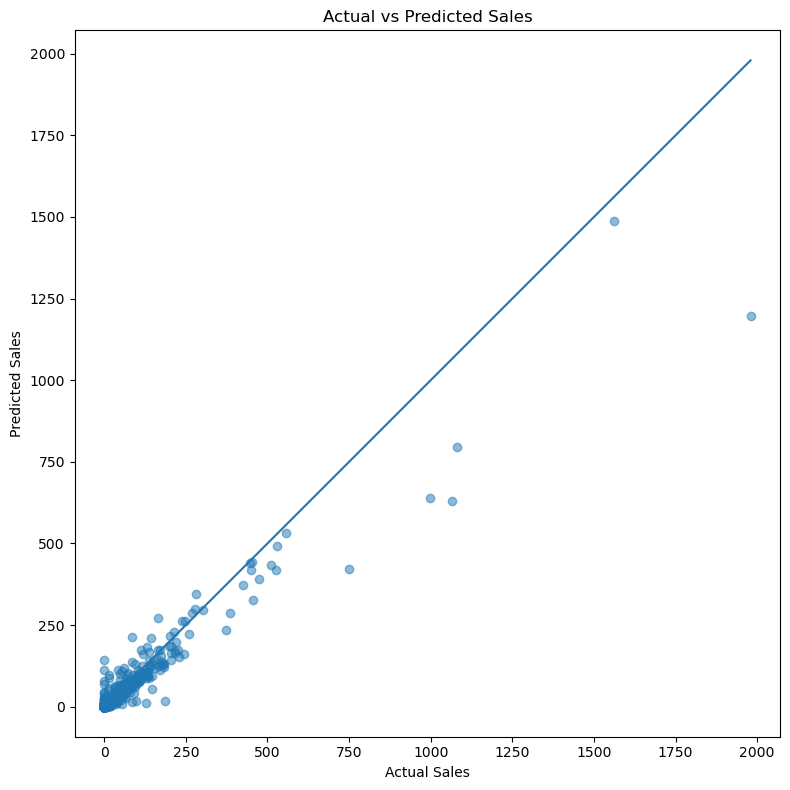

In [125]:
# Grafico prediccion vs real

plt.figure(figsize=(8, 8))
plt.scatter(valid_df['tn'], valid_df['forecast_tn'], alpha=0.5)

# Diagonal 45° line (ideal prediction)
min_val = min(valid_df['tn'].min(), valid_df['forecast_tn'].min())
max_val = max(valid_df['tn'].max(), valid_df['forecast_tn'].max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.axis('equal')  # ensure the scales are the same on both axes
plt.tight_layout()
plt.show()

In [127]:
# PARA DEC 2019 (o sea Feb2020)

# ensure periodo is datetime
monthly_full['periodo'] = pd.to_datetime(monthly_full['periodo'])

# define your 12-month window
last_date = pd.to_datetime(cut_test)
start_date = last_date - pd.DateOffset(months=12) + pd.DateOffset(days=1)

# filter to that window
mask = (monthly_full['periodo'] >= start_date) & (monthly_full['periodo'] <= last_date)
window_df = monthly_full.loc[mask]

# compute the mean tn per product_id
avg_12m = (
    window_df
    .groupby('product_id')['tn']
    .mean()
    .reset_index(name='avg_sales_last_12m')
)

print(avg_12m.head())



   product_id  avg_sales_last_12m
0       20001         1454.732717
1       20002         1175.437148
2       20003          784.976414
3       20004          627.215322
4       20005          668.270117


Keep products to predict


In [133]:
# Abrimos el archivo con los productos que queremos predecir
to_predict = pd.read_csv("datasets/a_predecir.txt", dtype={"product_id": str})
product_ids = to_predict['product_id'].astype(str).unique()

In [134]:
df_filtered = forecast_feb2020[
    forecast_feb2020['product_id'].astype(str).isin(product_ids)
].copy()

# Rename forecast_tn to tn
df_filtered.rename(columns={"forecast_tn": "tn"}, inplace=True)

# Now `df_filtered` contains only the products you care about.
print(df_filtered.head())

print(len(df_filtered))

   product_id           tn
0       20001  1554.883726
1       20002  1011.220768
2       20003   709.875930
3       20004   532.770349
4       20005   452.490438
780


In [135]:
df_filtered.to_csv("lr_clusterizado_dtw.csv", index=False)